# Voting Ensemble

ref: https://machinelearningmastery.com/voting-ensembles-with-python/

## Intro

- 重复多次，并以少数服从多数的方法确定正确的值


- combines the predictions from multiple other models


- 一般情况下，错误总是发生在局部，因此融合多个数据是降低误差的一个好方法。


- 对于回归模型，投票法最终的预测结果是多个其他回归模型预测结果的**平均值**。


- 对于分类模型，硬投票法（hard voting）的预测结果是多个模型预测结果中出现**次数最多**的类别(summing the votes)；软投票(soft voting)对各类预测结果的概率进行求和，最终选取**概率之和最大**的类标签(summing the predicted probabilities)。


- may be considered as a meta-model, could be used with any collection of existing trained machine learning models and the existing models do not need to be aware that they are being used in the ensemble.

Adv:

- can offer lower variance in the predictions made over individual models. 


- a lower variance in prediction error for regression tasks, a lower variance in accuracy for classification tasks. 

- This lower variance may result in a lower mean performance of the ensemble, which might be desirable given the higher stability or confidence of the model.

Limitations:


it treats all models the same, meaning all models contribute equally to the prediction.


Extensions to voting ensembles:Weighted Average Ensemble (blending), Stacked Generalization (stacking)

## Condition

- All models in the ensemble have generally the same good performance.


- All models in the ensemble mostly already agree.


## sklearn

- API-VotingRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html


- API-VotingClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html


- requires to specify a list of estimators that make predictions and are combined in the voting ensemble.


- A list of base models is provided via the *estimators* argument. 
  
  *estimators* is a list of tuples with the name of the model. Each model in the list must have a unique name.

## Classification

In [1]:
import sklearn
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
# test classification dataset
from sklearn.datasets import make_classification
# create a binary classification dataset with 1,000 examples and 20 input features
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=2)

### Hard Voting

- sum the predictions for each class label and predict the class label with the most votes.


- for models that predict class labels

In [3]:
# KNN algorithm

# get a voting ensemble of models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
def get_voting():
    # define the base models
    models = list()
    models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
    models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
    models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
    models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
    models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='hard')
    return ensemble

In [4]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['knn1'] = KNeighborsClassifier(n_neighbors=1)
    models['knn3'] = KNeighborsClassifier(n_neighbors=3)
    models['knn5'] = KNeighborsClassifier(n_neighbors=5)
    models['knn7'] = KNeighborsClassifier(n_neighbors=7)
    models['knn9'] = KNeighborsClassifier(n_neighbors=9)
    models['hard_voting'] = get_voting()
    return models

In [5]:
# evaluate a give model using cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
def evaluate_model(model, X, y):
    """
    takes a model instance 
    returns as a list of scores from three repeats of stratified 10-fold cross-validation.
    """
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>knn1 0.873 (0.030)
>knn3 0.889 (0.038)
>knn5 0.895 (0.031)
>knn7 0.899 (0.035)
>knn9 0.900 (0.033)
>hard_voting 0.902 (0.034)


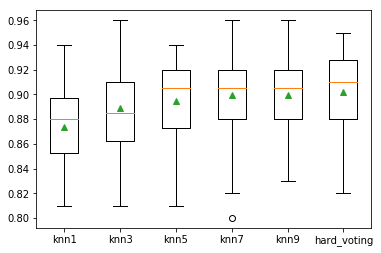

In [6]:
import numpy as np
from matplotlib import pyplot
from sklearn.datasets import make_classification

# create a binary classification dataset with 1,000 examples and 20 input features
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=2)

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    # print the result first report mean second report standard deviation
    
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [7]:
models = list()
models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
ensemble = VotingClassifier(estimators=models, voting='hard')

# fit the model on data
ensemble.fit(X,y)

# make a prediction
data = [[5.88891819,2.64867662,-0.42728226,-1.24988856,-0.00822,-3.57895574,2.87938412,-1.55614691,-0.38168784,7.50285659,-1.16710354,-5.02492712,-0.46196105,-0.64539455,-1.71297469,0.25987852,-0.193401,-5.52022952,0.0364453,-1.960039]]
yhat = ensemble.predict(data)
print('Predicted Class: %d' % (yhat))

Predicted Class: 1


### Soft Voting

- sum the predicted probabilities (or probability-like scores) for each class label and predict the class label with the largest summed probability.


- for models that predict class membership probabilities


- can be used for models that do not natively predict a class membership probability such as support vector machine, k-nearest neighbors, and decision trees (require calibration of their probability-like scores prior to being used in the ensemble)

In [8]:
# support vector machine does not natively predict probabilities, but can set probability=True

# get a voting ensemble of models
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
def get_voting():
    # define the base models
    models = list()
    #fit SVM algorithm with a polynomial kernel and a different polynomial degree
    models.append(('svm1',SVC(probability = True, kernel = 'poly', degree=1)))
    models.append(('svm2',SVC(probability = True, kernel = 'poly', degree=2)))
    models.append(('svm3',SVC(probability = True, kernel = 'poly', degree=3)))
    models.append(('svm4',SVC(probability = True, kernel = 'poly', degree=4)))
    models.append(('svm5',SVC(probability = True, kernel = 'poly', degree=5)))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='soft')
    return ensemble

In [9]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['svm1'] = SVC(probability = True, kernel = 'poly', degree=1)
    models['svm2'] = SVC(probability = True, kernel = 'poly', degree=2)
    models['svm3'] = SVC(probability = True, kernel = 'poly', degree=3)
    models['svm4'] = SVC(probability = True, kernel = 'poly', degree=4)
    models['svm5'] = SVC(probability = True, kernel = 'poly', degree=5)
    models['soft_voting'] = get_voting()
    return models

>svm1 0.855 (0.035)
>svm2 0.859 (0.034)
>svm3 0.890 (0.035)
>svm4 0.808 (0.037)
>svm5 0.850 (0.037)
>soft_voting 0.924 (0.027)


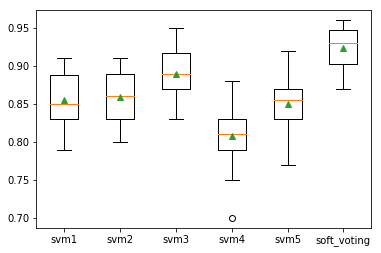

In [10]:
import numpy as np
from matplotlib import pyplot
from sklearn.datasets import make_classification

# create a binary classification dataset with 1,000 examples and 20 input features
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=2)

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    # print the result first report mean second report standard deviation
    
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Regression

In [11]:
# decision tree regressor

# get a voting ensemble of models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
def get_voting():
    # define the base models
    models = list()
    #fit SVM algorithm with a polynomial kernel and a different polynomial degree
    models.append(('decisiontree1',DecisionTreeRegressor(max_depth=1)))
    models.append(('decisiontree2',DecisionTreeRegressor(max_depth=2)))
    models.append(('decisiontree3',DecisionTreeRegressor(max_depth=3)))
    models.append(('decisiontree4',DecisionTreeRegressor(max_depth=4)))
    models.append(('decisiontree5',DecisionTreeRegressor(max_depth=5)))
    # define the voting ensemble
    ensemble = VotingRegressor(estimators=models)
    return ensemble

In [12]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['decisiontree1'] = DecisionTreeRegressor(max_depth=1)
    models['decisiontree2'] = DecisionTreeRegressor(max_depth=2)
    models['decisiontree3'] = DecisionTreeRegressor(max_depth=3)
    models['decisiontree4'] = DecisionTreeRegressor(max_depth=4)
    models['decisiontree5'] = DecisionTreeRegressor(max_depth=5)
    models['voting'] = get_voting()
    return models

In [13]:
# evaluate a give model using cross-validation
from sklearn.model_selection import RepeatedKFold
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>decisiontree1 -161.519 (11.414)
>decisiontree2 -152.596 (11.271)
>decisiontree3 -142.378 (10.900)
>decisiontree4 -140.086 (12.469)
>decisiontree5 -137.457 (12.397)
>voting -136.346 (11.290)


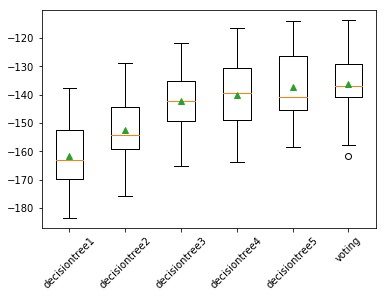

In [18]:
from sklearn.datasets import make_regression

# create a binary classification dataset with 1,000 examples and 20 input features
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    # print the result first report mean second report standard deviation
    
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()